# 모듈 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import cv2
import itertools

from dataloader_distance import *

# Linear Regression : 전체 속도

In [15]:
file_path_train = "D:\gait_dataset/salted/train/*"
_, _, y_train = get_sensor_salted(file_path_train)
inputs_pst_train = get_position_salted(file_path_train, distance=True)

file_path_test = "D:\gait_dataset/salted/test/*"
_, _, y_test = get_sensor_salted(file_path_test)
inputs_pst_test = get_position_salted(file_path_test, distance=True)

In [16]:
x_train = pd.DataFrame(inputs_pst_train)
x_train.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

x_test = pd.DataFrame(inputs_pst_test)
x_test.columns =  ['R_DIS_X', 'R_DIS_Y', 'R_DIS_Z']

In [9]:
x_train

,R_DIS_X,R_DIS_Y,R_DIS_Z
0,0.649731,0.175308,0.404984
1,0.589614,0.170229,0.418297
2,0.707072,0.236557,0.277412
3,0.705076,0.213632,0.319986
4,0.715850,0.179020,0.290625
...,...,...,...
3349,0.648799,0.226499,0.524309
3350,0.673180,0.350159,0.512037
3351,0.631504,0.369093,0.332118
3352,0.574268,0.146589,0.530579


In [17]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [18]:
MAE = mean_absolute_error(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)
print('MAE : {:.4f}, Corr : {:.4f}'.format(MAE, corr[0, 1]))

MAE : 9.6073, Corr : 0.8433


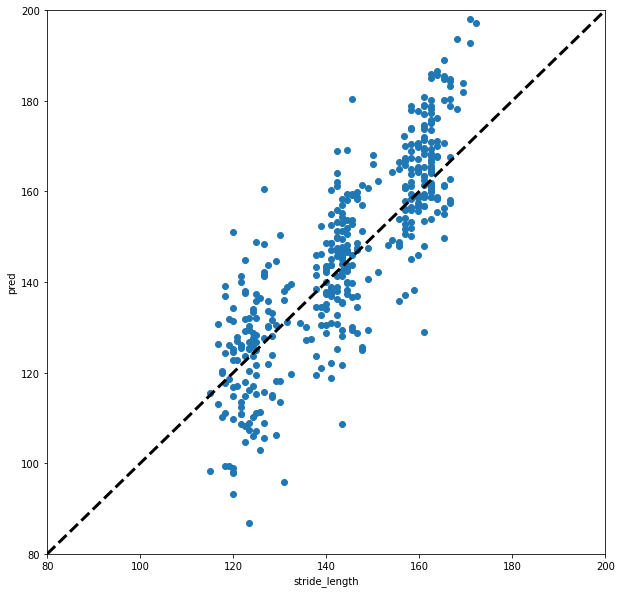

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 최종 노드 1개

## No bias
- Best Result : Epoch 263, Valid Loss 13.012, MAE 2.211, Corr 0.981159

### 데이터 불러오기 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [3]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1

In [17]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [18]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [20]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6833.716, Valid Loss 520.661, MAE 16.422, Corr 0.471495
Best Valid Loss 520.6606
Epoch : 2/2000, Train Loss : 641.003, Valid Loss 500.829, MAE 19.403, Corr 0.481525
Best Valid Loss 500.8291
Epoch : 3/2000, Train Loss : 286.259, Valid Loss 275.083, MAE 14.033, Corr 0.487616
Best Valid Loss 275.0827
Epoch : 4/2000, Train Loss : 237.705, Valid Loss 258.076, MAE 13.699, Corr 0.492403
Best Valid Loss 258.0759
Epoch : 5/2000, Train Loss : 230.718, Valid Loss 257.639, MAE 13.707, Corr 0.496933
Best Valid Loss 257.6388
Epoch : 6/2000, Train Loss : 228.278, Valid Loss 248.898, MAE 13.595, Corr 0.501034
Best Valid Loss 248.8983
Epoch : 7/2000, Train Loss : 224.364, Valid Loss 240.394, MAE 13.361, Corr 0.505959
Best Valid Loss 240.3943
Epoch : 8/2000, Train Loss : 224.529, Valid Loss 238.829, MAE 13.376, Corr 0.511374
Best Valid Loss 238.8285
Epoch : 9/2000, Train Loss : 225.849, Valid Loss 236.538, MAE 13.324, Corr 0.518321
Best Valid Loss 236.5384
Epoch : 10/2000, T

Epoch : 88/2000, Train Loss : 26.138, Valid Loss 24.176, MAE 3.693, Corr 0.965991
Epoch : 89/2000, Train Loss : 24.599, Valid Loss 28.790, MAE 4.031, Corr 0.968252
Epoch : 90/2000, Train Loss : 31.585, Valid Loss 23.028, MAE 3.483, Corr 0.966541
Best Valid Loss 23.0285
Epoch : 91/2000, Train Loss : 28.914, Valid Loss 35.170, MAE 4.589, Corr 0.968470
Epoch : 92/2000, Train Loss : 29.091, Valid Loss 28.114, MAE 3.944, Corr 0.971150
Epoch : 93/2000, Train Loss : 25.711, Valid Loss 23.495, MAE 3.694, Corr 0.965134
Epoch : 94/2000, Train Loss : 24.048, Valid Loss 23.850, MAE 3.582, Corr 0.964523
Epoch : 95/2000, Train Loss : 29.014, Valid Loss 23.885, MAE 3.557, Corr 0.968224
Epoch : 96/2000, Train Loss : 23.016, Valid Loss 23.601, MAE 3.523, Corr 0.967784
Epoch : 97/2000, Train Loss : 25.497, Valid Loss 22.395, MAE 3.435, Corr 0.967952
Best Valid Loss 22.3949
Epoch : 98/2000, Train Loss : 32.525, Valid Loss 34.650, MAE 4.707, Corr 0.965021
Epoch : 99/2000, Train Loss : 24.880, Valid Loss 2

Epoch : 184/2000, Train Loss : 15.039, Valid Loss 24.368, MAE 3.885, Corr 0.978042
Epoch : 185/2000, Train Loss : 21.333, Valid Loss 28.400, MAE 4.330, Corr 0.973682
Epoch : 186/2000, Train Loss : 23.678, Valid Loss 50.092, MAE 5.599, Corr 0.980748
Epoch : 187/2000, Train Loss : 29.321, Valid Loss 18.770, MAE 3.269, Corr 0.977170
Epoch : 188/2000, Train Loss : 20.941, Valid Loss 16.078, MAE 2.740, Corr 0.978029
Epoch : 189/2000, Train Loss : 15.764, Valid Loss 17.541, MAE 3.097, Corr 0.975652
Epoch : 190/2000, Train Loss : 18.704, Valid Loss 19.830, MAE 3.283, Corr 0.973922
Epoch : 191/2000, Train Loss : 16.222, Valid Loss 19.306, MAE 3.232, Corr 0.977517
Epoch : 192/2000, Train Loss : 17.929, Valid Loss 15.634, MAE 2.620, Corr 0.977220
Best Valid Loss 15.6344
Epoch : 193/2000, Train Loss : 18.635, Valid Loss 17.598, MAE 3.253, Corr 0.970779
Epoch : 194/2000, Train Loss : 15.427, Valid Loss 17.099, MAE 2.847, Corr 0.979800
Epoch : 195/2000, Train Loss : 17.836, Valid Loss 22.674, MAE 3

Epoch : 280/2000, Train Loss : 19.304, Valid Loss 23.391, MAE 3.881, Corr 0.978978
Epoch : 281/2000, Train Loss : 14.978, Valid Loss 13.024, MAE 2.784, Corr 0.978386
Early stopping
Best Result : Epoch 260, Valid Loss 12.724, MAE 2.638, Corr 0.979675


In [21]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [22]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_nobias.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

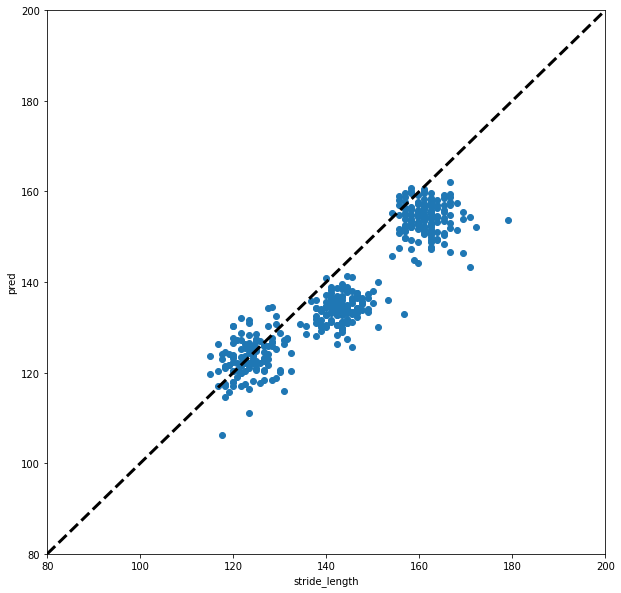

In [23]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## Bias
- Best Result : Epoch 313, Valid Loss 10.596, MAE 2.744, Corr 0.976224

### 데이터 불러오기 

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=True)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [15]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- 인코더에 Conv1d만을 사용
- 인코더의 아웃풋 길이가 늘어나 FC Layer의 수를 늘려 실험
    - FC Layer : enc_output -> 512 -> 256 -> 128 -> 64 -> 32 -> 1

In [16]:
# seed 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Encoder(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense = nn.Sequential(
            nn.Linear(7744*2, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        enc_output = torch.concat((conv1d_output_acc, conv1d_output_gyr), 1)
        dense_output = self.dense(enc_output)
        
        return dense_output

In [17]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [18]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, _ = data
        inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
        inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()

        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, _ = data
            inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
            inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_1_best_ks30_bias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 6744.895, Valid Loss 783.600, MAE 27.136, Corr 0.023566
Best Valid Loss 783.6002
Epoch : 2/2000, Train Loss : 587.428, Valid Loss 352.932, MAE 12.824, Corr 0.064475
Best Valid Loss 352.9320
Epoch : 3/2000, Train Loss : 277.999, Valid Loss 253.815, MAE 11.697, Corr 0.087255
Best Valid Loss 253.8146
Epoch : 4/2000, Train Loss : 237.259, Valid Loss 251.216, MAE 11.707, Corr 0.104823
Best Valid Loss 251.2164
Epoch : 5/2000, Train Loss : 236.936, Valid Loss 241.139, MAE 11.785, Corr 0.120193
Best Valid Loss 241.1391
Epoch : 6/2000, Train Loss : 232.600, Valid Loss 232.550, MAE 12.672, Corr 0.133611
Best Valid Loss 232.5495
Epoch : 7/2000, Train Loss : 230.153, Valid Loss 275.914, MAE 11.903, Corr 0.146945
Epoch : 8/2000, Train Loss : 231.031, Valid Loss 231.505, MAE 12.859, Corr 0.159554
Best Valid Loss 231.5050
Epoch : 9/2000, Train Loss : 221.526, Valid Loss 226.479, MAE 11.948, Corr 0.175167
Best Valid Loss 226.4786
Epoch : 10/2000, Train Loss : 222.522, Vali

Epoch : 89/2000, Train Loss : 24.939, Valid Loss 26.155, MAE 3.712, Corr 0.957608
Epoch : 90/2000, Train Loss : 24.857, Valid Loss 38.222, MAE 5.400, Corr 0.957677
Epoch : 91/2000, Train Loss : 27.200, Valid Loss 49.159, MAE 6.440, Corr 0.959607
Epoch : 92/2000, Train Loss : 43.711, Valid Loss 64.878, MAE 5.952, Corr 0.950347
Epoch : 93/2000, Train Loss : 30.474, Valid Loss 25.670, MAE 3.469, Corr 0.958812
Best Valid Loss 25.6699
Epoch : 94/2000, Train Loss : 39.625, Valid Loss 48.122, MAE 6.163, Corr 0.946228
Epoch : 95/2000, Train Loss : 34.286, Valid Loss 36.172, MAE 5.120, Corr 0.956447
Epoch : 96/2000, Train Loss : 26.281, Valid Loss 30.288, MAE 4.491, Corr 0.957653
Epoch : 97/2000, Train Loss : 24.872, Valid Loss 32.143, MAE 4.685, Corr 0.957510
Epoch : 98/2000, Train Loss : 27.318, Valid Loss 39.347, MAE 4.230, Corr 0.957136
Epoch : 99/2000, Train Loss : 33.539, Valid Loss 25.561, MAE 3.487, Corr 0.959481
Best Valid Loss 25.5605
Epoch : 100/2000, Train Loss : 25.320, Valid Loss 

Epoch : 183/2000, Train Loss : 21.859, Valid Loss 37.264, MAE 4.220, Corr 0.967675
Epoch : 184/2000, Train Loss : 23.738, Valid Loss 16.722, MAE 3.167, Corr 0.966282
Best Valid Loss 16.7223
Epoch : 185/2000, Train Loss : 18.618, Valid Loss 16.151, MAE 2.941, Corr 0.967526
Best Valid Loss 16.1508
Epoch : 186/2000, Train Loss : 20.832, Valid Loss 23.660, MAE 3.588, Corr 0.969890
Epoch : 187/2000, Train Loss : 17.622, Valid Loss 19.616, MAE 3.362, Corr 0.967983
Epoch : 188/2000, Train Loss : 17.146, Valid Loss 28.146, MAE 4.568, Corr 0.966775
Epoch : 189/2000, Train Loss : 16.619, Valid Loss 17.995, MAE 3.373, Corr 0.966584
Epoch : 190/2000, Train Loss : 17.307, Valid Loss 18.805, MAE 3.255, Corr 0.967671
Epoch : 191/2000, Train Loss : 16.612, Valid Loss 19.992, MAE 3.634, Corr 0.964438
Epoch : 192/2000, Train Loss : 21.106, Valid Loss 41.109, MAE 4.842, Corr 0.968431
Epoch : 193/2000, Train Loss : 18.433, Valid Loss 23.320, MAE 4.006, Corr 0.966577
Epoch : 194/2000, Train Loss : 20.731, 

Epoch : 278/2000, Train Loss : 18.334, Valid Loss 11.990, MAE 2.938, Corr 0.971612
Best Valid Loss 11.9903
Epoch : 279/2000, Train Loss : 11.093, Valid Loss 13.659, MAE 2.955, Corr 0.974177
Epoch : 280/2000, Train Loss : 12.522, Valid Loss 12.123, MAE 2.749, Corr 0.972369
Epoch : 281/2000, Train Loss : 10.862, Valid Loss 12.064, MAE 2.591, Corr 0.973861
Epoch : 282/2000, Train Loss : 11.316, Valid Loss 14.193, MAE 3.021, Corr 0.973361
Epoch : 283/2000, Train Loss : 14.385, Valid Loss 18.436, MAE 3.491, Corr 0.972658
Epoch : 284/2000, Train Loss : 20.381, Valid Loss 15.081, MAE 2.940, Corr 0.974059
Epoch : 285/2000, Train Loss : 28.164, Valid Loss 21.842, MAE 3.586, Corr 0.971382
Epoch : 286/2000, Train Loss : 22.991, Valid Loss 37.562, MAE 4.809, Corr 0.972219
Epoch : 287/2000, Train Loss : 15.528, Valid Loss 12.260, MAE 2.554, Corr 0.975452
Epoch : 288/2000, Train Loss : 12.815, Valid Loss 17.815, MAE 3.353, Corr 0.975585
Epoch : 289/2000, Train Loss : 12.193, Valid Loss 12.762, MAE 2

In [19]:
### scatter plot
file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_acc, inputs_gyr, stride_length = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length))
inputs_acc, inputs_gyr, stride_length = inputs_acc.float(), inputs_gyr.float(), stride_length.float()
inputs_acc, inputs_gyr = inputs_acc.to(device), inputs_gyr.to(device)

In [20]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_1_best_ks30_bias.pth'))
model.eval()

Encoder(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense): Sequential(
    (0): Linear(in_features=15488, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

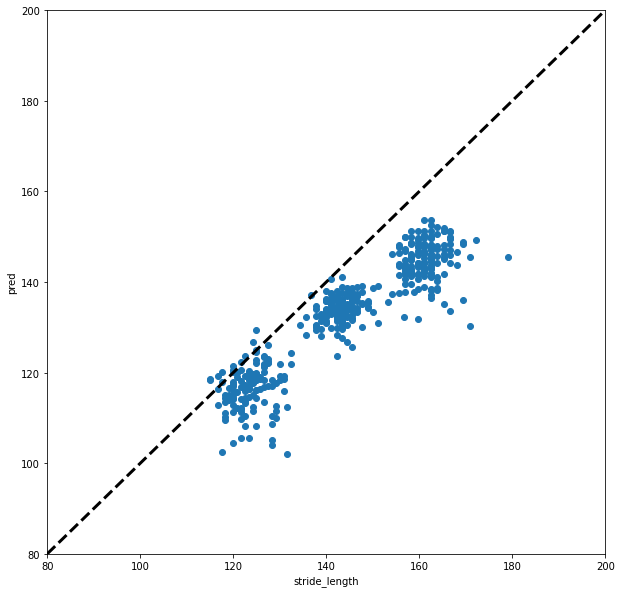

In [21]:
pred = model(inputs_acc, inputs_gyr).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : 3 node
- 가속도 데이터만 사용한 output에 각 축별 distance를 곱
- 자이로는 노드 하나로 빼서 마지막에 더하기 

## 전체 데이터 사용

### 데이터 불러오기 

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=False)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [24]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot
- Best Result : Epoch 259, Valid Loss 40.381912, MAE 4.223338

In [25]:
# seed 고정
random_seed=42
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense_acc = nn.Sequential(
            nn.Linear(7744, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        
        self.dense_gyr = nn.Sequential(
            nn.Linear(7744, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        acc_enc_output = self.dense_acc(conv1d_output_acc)
        gyr_enc_output = self.dense_gyr(conv1d_output_gyr)
        dist_enc_output = torch.unsqueeze(torch.sum(acc_enc_output*inputs_pst, axis=1), 1)
        output = dist_enc_output+gyr_enc_output
        
        return output

In [26]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [27]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst, _ = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst, _ = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_nobias.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 7539.783, Valid Loss 262.892, MAE 11.586, Corr 0.783975
Best Valid Loss 262.8921
Epoch : 2/2000, Train Loss : 511.572, Valid Loss 263.197, MAE 11.468, Corr 0.800728
Epoch : 3/2000, Train Loss : 197.330, Valid Loss 142.390, MAE 8.240, Corr 0.820629
Best Valid Loss 142.3898
Epoch : 4/2000, Train Loss : 141.048, Valid Loss 127.700, MAE 7.794, Corr 0.821850
Best Valid Loss 127.7005
Epoch : 5/2000, Train Loss : 122.272, Valid Loss 119.474, MAE 8.246, Corr 0.818695
Best Valid Loss 119.4741
Epoch : 6/2000, Train Loss : 113.650, Valid Loss 113.722, MAE 8.001, Corr 0.822126
Best Valid Loss 113.7225
Epoch : 7/2000, Train Loss : 110.571, Valid Loss 109.869, MAE 7.698, Corr 0.826450
Best Valid Loss 109.8691
Epoch : 8/2000, Train Loss : 107.469, Valid Loss 109.818, MAE 7.027, Corr 0.829643
Best Valid Loss 109.8179
Epoch : 9/2000, Train Loss : 107.434, Valid Loss 108.654, MAE 6.858, Corr 0.833770
Best Valid Loss 108.6541
Epoch : 10/2000, Train Loss : 111.131, Valid Loss 

Epoch : 88/2000, Train Loss : 30.059, Valid Loss 24.214, MAE 3.837, Corr 0.971071
Epoch : 89/2000, Train Loss : 23.235, Valid Loss 16.664, MAE 2.674, Corr 0.970826
Best Valid Loss 16.6643
Epoch : 90/2000, Train Loss : 18.569, Valid Loss 19.006, MAE 2.995, Corr 0.973081
Epoch : 91/2000, Train Loss : 17.419, Valid Loss 18.948, MAE 3.029, Corr 0.971900
Epoch : 92/2000, Train Loss : 22.335, Valid Loss 17.741, MAE 2.968, Corr 0.971480
Epoch : 93/2000, Train Loss : 18.113, Valid Loss 16.167, MAE 2.630, Corr 0.973202
Best Valid Loss 16.1666
Epoch : 94/2000, Train Loss : 18.891, Valid Loss 20.785, MAE 3.427, Corr 0.970753
Epoch : 95/2000, Train Loss : 16.891, Valid Loss 22.870, MAE 3.652, Corr 0.970417
Epoch : 96/2000, Train Loss : 22.075, Valid Loss 17.994, MAE 2.852, Corr 0.968999
Epoch : 97/2000, Train Loss : 24.574, Valid Loss 17.732, MAE 2.951, Corr 0.975315
Epoch : 98/2000, Train Loss : 23.984, Valid Loss 19.886, MAE 3.301, Corr 0.973809
Epoch : 99/2000, Train Loss : 22.839, Valid Loss 1

Epoch : 183/2000, Train Loss : 9.017, Valid Loss 14.038, MAE 3.156, Corr 0.987098
Epoch : 184/2000, Train Loss : 13.390, Valid Loss 8.669, MAE 2.385, Corr 0.987617
Epoch : 185/2000, Train Loss : 10.408, Valid Loss 11.197, MAE 2.900, Corr 0.986787
Epoch : 186/2000, Train Loss : 9.749, Valid Loss 15.677, MAE 3.442, Corr 0.987762
Epoch : 187/2000, Train Loss : 8.973, Valid Loss 11.188, MAE 2.468, Corr 0.987427
Epoch : 188/2000, Train Loss : 13.044, Valid Loss 11.856, MAE 2.877, Corr 0.986205
Epoch : 189/2000, Train Loss : 16.840, Valid Loss 8.013, MAE 2.156, Corr 0.984882
Epoch : 190/2000, Train Loss : 8.133, Valid Loss 8.342, MAE 2.263, Corr 0.987437
Epoch : 191/2000, Train Loss : 7.997, Valid Loss 9.222, MAE 2.436, Corr 0.987232
Epoch : 192/2000, Train Loss : 11.925, Valid Loss 13.509, MAE 3.116, Corr 0.986942
Epoch : 193/2000, Train Loss : 8.418, Valid Loss 7.857, MAE 2.016, Corr 0.987933
Epoch : 194/2000, Train Loss : 8.036, Valid Loss 10.768, MAE 2.585, Corr 0.987877
Epoch : 195/2000

Epoch : 280/2000, Train Loss : 4.843, Valid Loss 6.712, MAE 2.067, Corr 0.991259
Epoch : 281/2000, Train Loss : 8.077, Valid Loss 16.118, MAE 3.388, Corr 0.990867
Epoch : 282/2000, Train Loss : 15.117, Valid Loss 5.666, MAE 1.993, Corr 0.990018
Epoch : 283/2000, Train Loss : 7.824, Valid Loss 17.226, MAE 3.567, Corr 0.991692
Epoch : 284/2000, Train Loss : 17.162, Valid Loss 7.204, MAE 2.053, Corr 0.990313
Epoch : 285/2000, Train Loss : 8.537, Valid Loss 4.644, MAE 1.608, Corr 0.991651
Epoch : 286/2000, Train Loss : 6.666, Valid Loss 7.776, MAE 2.330, Corr 0.991873
Epoch : 287/2000, Train Loss : 10.003, Valid Loss 16.466, MAE 3.598, Corr 0.989569
Epoch : 288/2000, Train Loss : 12.157, Valid Loss 5.674, MAE 1.744, Corr 0.992291
Epoch : 289/2000, Train Loss : 5.012, Valid Loss 5.377, MAE 2.019, Corr 0.991126
Epoch : 290/2000, Train Loss : 4.409, Valid Loss 5.435, MAE 1.790, Corr 0.991977
Epoch : 291/2000, Train Loss : 4.810, Valid Loss 5.787, MAE 2.059, Corr 0.991697
Epoch : 292/2000, Tra

In [28]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [29]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_nobias.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_acc): Sequential(
    (0): Linear(in_features=7744, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
  (dense_gyr): Sequential(
    (0): Linear(in_features

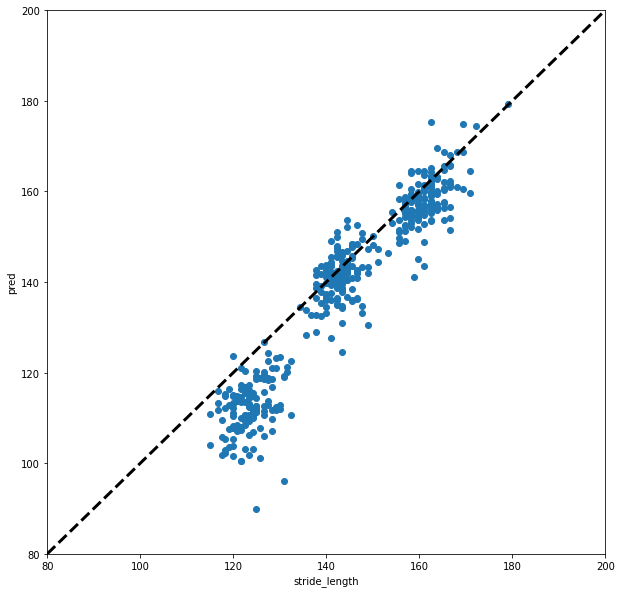

In [14]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

## 3km

### 데이터 불러오기 

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Salted(file_path, bias=True)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [39]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

### Model & Scatter Plot


In [40]:
# seed 고정
random_seed=42
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random

class Encoder_dist(nn.Module):
    def __init__(self, input_dim, conv1d_dim1, conv1d_dim2, dense_dim):
        super(Encoder_dist, self).__init__()
             
        self.conv1d_acc = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.conv1d_gyr = nn.Sequential(
            nn.Conv1d(input_dim, conv1d_dim1, 30),
            nn.ReLU(inplace=True),
            nn.Conv1d(conv1d_dim1, conv1d_dim2, 30),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )
        
        self.dense_acc = nn.Sequential(
            nn.Linear(7744, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 3)
        )
        
        self.dense_gyr = nn.Sequential(
            nn.Linear(7744, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        

    def forward(self, inputs_acc, inputs_gyr, inputs_pst): 
        
        conv1d_output_acc = self.conv1d_acc(inputs_acc)
        conv1d_output_gyr = self.conv1d_gyr(inputs_gyr)
        
        acc_enc_output = self.dense_acc(conv1d_output_acc)
        gyr_enc_output = self.dense_gyr(conv1d_output_gyr)
        dist_enc_output = torch.unsqueeze(torch.sum(acc_enc_output*inputs_pst, axis=1), 1)
        output = dist_enc_output+gyr_enc_output
        
        return output

In [41]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [42]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, stride_length, inputs_pst, _ = data
        inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
        inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_pst)

        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, stride_length, inputs_pst, _ = data
            inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
            inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_pst)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    corr = torch.corrcoef(torch.stack([torch.squeeze(stride_length), torch.squeeze(outputs)]))[0, 1]
    
    
    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE, corr))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_corr = corr
        best_epoch = epoch+1
        torch.save(model.state_dict(), './model/encoder_dist_best_ks30_bias_spd3.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}, Corr {:3f}'.format(best_epoch, best, best_MAE, best_corr))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 7201.010, Valid Loss 288.974, MAE 11.616, Corr 0.518029
Best Valid Loss 288.9744
Epoch : 2/2000, Train Loss : 515.367, Valid Loss 390.502, MAE 16.265, Corr 0.528265
Epoch : 3/2000, Train Loss : 249.289, Valid Loss 272.000, MAE 12.807, Corr 0.541394
Best Valid Loss 271.9999
Epoch : 4/2000, Train Loss : 225.229, Valid Loss 240.410, MAE 11.809, Corr 0.557531
Best Valid Loss 240.4097
Epoch : 5/2000, Train Loss : 207.849, Valid Loss 213.238, MAE 10.952, Corr 0.572485
Best Valid Loss 213.2376
Epoch : 6/2000, Train Loss : 200.000, Valid Loss 210.796, MAE 10.769, Corr 0.589268
Best Valid Loss 210.7963
Epoch : 7/2000, Train Loss : 194.536, Valid Loss 205.934, MAE 10.707, Corr 0.604126
Best Valid Loss 205.9339
Epoch : 8/2000, Train Loss : 189.845, Valid Loss 202.539, MAE 10.566, Corr 0.614226
Best Valid Loss 202.5391
Epoch : 9/2000, Train Loss : 186.341, Valid Loss 201.064, MAE 10.345, Corr 0.625617
Best Valid Loss 201.0638
Epoch : 10/2000, Train Loss : 186.430, Vali

Epoch : 87/2000, Train Loss : 23.960, Valid Loss 22.423, MAE 3.113, Corr 0.958297
Best Valid Loss 22.4234
Epoch : 88/2000, Train Loss : 21.853, Valid Loss 39.672, MAE 4.807, Corr 0.961036
Epoch : 89/2000, Train Loss : 32.804, Valid Loss 25.307, MAE 3.479, Corr 0.960720
Epoch : 90/2000, Train Loss : 21.445, Valid Loss 22.743, MAE 3.382, Corr 0.965365
Epoch : 91/2000, Train Loss : 19.411, Valid Loss 26.032, MAE 3.514, Corr 0.963086
Epoch : 92/2000, Train Loss : 17.542, Valid Loss 20.772, MAE 2.997, Corr 0.964668
Best Valid Loss 20.7721
Epoch : 93/2000, Train Loss : 25.333, Valid Loss 21.752, MAE 2.889, Corr 0.963964
Epoch : 94/2000, Train Loss : 28.883, Valid Loss 45.705, MAE 5.530, Corr 0.962944
Epoch : 95/2000, Train Loss : 21.031, Valid Loss 21.450, MAE 2.919, Corr 0.966036
Epoch : 96/2000, Train Loss : 20.647, Valid Loss 21.052, MAE 3.589, Corr 0.965036
Epoch : 97/2000, Train Loss : 19.100, Valid Loss 25.626, MAE 3.352, Corr 0.964957
Epoch : 98/2000, Train Loss : 25.961, Valid Loss 5

Epoch : 182/2000, Train Loss : 6.342, Valid Loss 7.829, MAE 2.319, Corr 0.981543
Best Valid Loss 7.8288
Epoch : 183/2000, Train Loss : 6.734, Valid Loss 8.549, MAE 2.483, Corr 0.982098
Epoch : 184/2000, Train Loss : 7.444, Valid Loss 7.761, MAE 2.186, Corr 0.983070
Best Valid Loss 7.7608
Epoch : 185/2000, Train Loss : 6.505, Valid Loss 9.065, MAE 2.505, Corr 0.981399
Epoch : 186/2000, Train Loss : 9.612, Valid Loss 19.796, MAE 4.096, Corr 0.982280
Epoch : 187/2000, Train Loss : 9.281, Valid Loss 14.996, MAE 3.414, Corr 0.982090
Epoch : 188/2000, Train Loss : 14.757, Valid Loss 12.825, MAE 3.177, Corr 0.980435
Epoch : 189/2000, Train Loss : 8.259, Valid Loss 20.690, MAE 3.392, Corr 0.981133
Epoch : 190/2000, Train Loss : 6.412, Valid Loss 7.262, MAE 2.036, Corr 0.984255
Best Valid Loss 7.2621
Epoch : 191/2000, Train Loss : 6.443, Valid Loss 9.648, MAE 2.651, Corr 0.984390
Epoch : 192/2000, Train Loss : 9.228, Valid Loss 7.830, MAE 2.350, Corr 0.983738
Epoch : 193/2000, Train Loss : 11.6

In [43]:
# scatter plot

file_path = "D:\gait_dataset/salted/test/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=True)
inputs_pst = get_position_salted(file_path, distance=True, bias=True)
inputs_acc, inputs_gyr, stride_length, inputs_pst = torch.Tensor(np.array(inputs_acc)), torch.Tensor(np.array(inputs_gyr)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_acc, inputs_gyr, stride_length, inputs_pst = inputs_acc.float(), inputs_gyr.float(), stride_length.float(), inputs_pst.float()
inputs_acc, inputs_gyr, inputs_pst = inputs_acc.to(device), inputs_gyr.to(device), inputs_pst.to(device)

In [44]:
input_dim = 3
conv1d_dim1 = 16
conv1d_dim2 = 32
dense_dim = 512

model = Encoder_dist(input_dim, conv1d_dim1, conv1d_dim2, dense_dim).to(device)
model.load_state_dict(torch.load('./model/encoder_dist_best_ks30_bias_spd3.pth'))
model.eval()

Encoder_dist(
  (conv1d_acc): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (conv1d_gyr): Sequential(
    (0): Conv1d(3, 16, kernel_size=(30,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(30,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense_acc): Sequential(
    (0): Linear(in_features=7744, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
  (dense_gyr): Sequential(
    (0): Linear(in_features

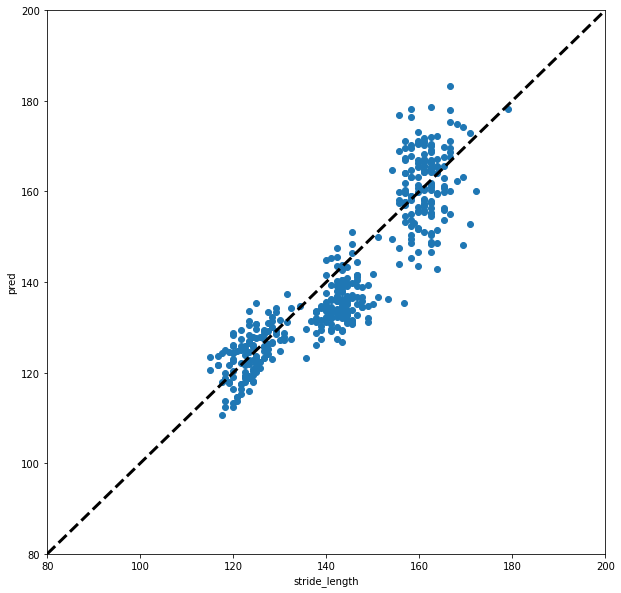

In [45]:
pred = model(inputs_acc, inputs_gyr, inputs_pst).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

# Encoder-based Model : Acc, Gyro 축별 입력
- 각 축 Acc에서 얻어진 축별 distance를 곱해주기 때문에 축별로 데이터를 입력
    - 축별 Acc/Gyro의 정보가 알맞은 축의 distance와 곱해져야 한다는 생각에 시도
- 3개의 인코더에는 각각 (Acc_x, Gyro_x) / (Acc_y, Gyro_y) / (Acc_z, Gyro_z)가 입력으로 들어감
    - 인코더의 각 output을 concat한 뒤 FC-Layer에 넣었을 때, 축별 정보가 순서대로 보존될 수 있을지는 의문 부호 
- Pressure는 축이 따로 없으므로 고려하지 않음

In [136]:
file_path = "D:\gait_dataset/salted/train/*"
dataset = Gait_Dataset_Axis_Salted(file_path)
val_percent = 0.2
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [137]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=128,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val,
                                         batch_size=128,
                                         shuffle=False)

In [138]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

class Encoder_axis(nn.Module):
    def __init__(self, input_dim, dense_dim):
        super(Encoder_axis, self).__init__()
        
        
        self.fc_x = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        self.fc_y = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        self.fc_z = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(inplace=True),
            nn.Linear(dense_dim, int(dense_dim/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/2), int(dense_dim/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/4), int(dense_dim/8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(dense_dim/8), 1)
        )
        
        

    def forward(self, inputs_x, inputs_y, inputs_z): 
        

        fc_output_x = self.fc_x(inputs_x)
        fc_output_y = self.fc_y(inputs_y)
        fc_output_z = self.fc_z(inputs_z)
        
        
        enc_output = torch.concat((fc_output_x, fc_output_y, fc_output_z), 1)
        output = torch.unsqueeze(torch.sum(enc_output*inputs_pst, axis=1), 1)

        return output

In [139]:
input_dim = 600
dense_dim = 512

model = Encoder_axis(input_dim, dense_dim).to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 2000

criterion = nn.MSELoss()

In [140]:
# Early Stopping을 위한 변수
best = 1000
converge_cnt = 0
best_MAE = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0
    
    # Train Mode
    model.train()
    
    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
        inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
        inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_x, inputs_y, inputs_z)
        
        # Loss 계산
        loss = criterion(outputs, stride_length)
        
        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()
        
        # Print statistics
        tot_trn_loss += loss.item()
        
    # Evaluation Mode
    model.eval()
    
    tot_val_loss = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = data
            inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
            inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_x, inputs_y, inputs_z)
            
            # Loss 계산
            loss = criterion(outputs, stride_length)
            tot_val_loss += loss.item()            
            

    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
    
    print("Epoch : {}/{}, Train Loss : {:.6f}, Valid Loss {:.6f}, MAE {:.6f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss,
                                                                                      MAE))
    
    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        torch.save(model.state_dict(), './encoder_axis_best.pth')
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1
    
    if converge_cnt > 20:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:4f}, MAE {:4f}'.format(best_epoch, best, best_MAE))
        break
    
#     print("Epoch : {}/{} Epoch Loss : {:.6f}".format(epoch+1, n_epochs, current_loss / len(trainloader.dataset)))

Epoch : 1/2000, Train Loss : 4204.483070, Valid Loss 960.211477, MAE 18.732618
Best Valid Loss 960.2115
Epoch : 2/2000, Train Loss : 740.092518, Valid Loss 682.783244, MAE 21.815802
Best Valid Loss 682.7832
Epoch : 3/2000, Train Loss : 672.514692, Valid Loss 643.312449, MAE 20.371880
Best Valid Loss 643.3124
Epoch : 4/2000, Train Loss : 654.339292, Valid Loss 623.736908, MAE 19.857491
Best Valid Loss 623.7369
Epoch : 5/2000, Train Loss : 643.132443, Valid Loss 608.725906, MAE 19.476088
Best Valid Loss 608.7259
Epoch : 6/2000, Train Loss : 629.894007, Valid Loss 597.531306, MAE 19.109816
Best Valid Loss 597.5313
Epoch : 7/2000, Train Loss : 618.994101, Valid Loss 586.731923, MAE 18.686306
Best Valid Loss 586.7319
Epoch : 8/2000, Train Loss : 620.693370, Valid Loss 594.880473, MAE 19.484201
Epoch : 9/2000, Train Loss : 599.383153, Valid Loss 564.362340, MAE 18.882992
Best Valid Loss 564.3623
Epoch : 10/2000, Train Loss : 597.239210, Valid Loss 600.098083, MAE 17.494865
Epoch : 11/2000, T

Epoch : 95/2000, Train Loss : 254.135312, Valid Loss 237.997208, MAE 13.818307
Best Valid Loss 237.9972
Epoch : 96/2000, Train Loss : 218.618420, Valid Loss 240.439158, MAE 13.829137
Epoch : 97/2000, Train Loss : 224.414599, Valid Loss 356.595851, MAE 14.280470
Epoch : 98/2000, Train Loss : 228.745526, Valid Loss 237.988360, MAE 13.156813
Best Valid Loss 237.9884
Epoch : 99/2000, Train Loss : 222.886017, Valid Loss 256.208115, MAE 14.809103
Epoch : 100/2000, Train Loss : 243.921161, Valid Loss 244.645859, MAE 13.140440
Epoch : 101/2000, Train Loss : 269.264781, Valid Loss 447.129400, MAE 14.575147
Epoch : 102/2000, Train Loss : 261.608053, Valid Loss 245.502991, MAE 14.338456
Epoch : 103/2000, Train Loss : 233.777489, Valid Loss 413.139114, MAE 14.149916
Epoch : 104/2000, Train Loss : 251.044906, Valid Loss 250.410014, MAE 14.467360
Epoch : 105/2000, Train Loss : 207.769081, Valid Loss 253.500000, MAE 14.559004
Epoch : 106/2000, Train Loss : 230.540902, Valid Loss 244.426598, MAE 13.54

In [141]:
file_path = "D:\gait_dataset/salted/test/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = torch.Tensor(np.array(inputs_x)), torch.Tensor(np.array(inputs_y)), torch.Tensor(np.array(inputs_z)), torch.Tensor(np.array(stride_length)), torch.Tensor(np.array(inputs_pst))
inputs_x, inputs_y, inputs_z, stride_length, inputs_pst = inputs_x.float(), inputs_y.float(), inputs_z.float(), stride_length.float(), inputs_pst.float()
inputs_x, inputs_y, inputs_z, inputs_pst = inputs_x.to(device), inputs_y.to(device), inputs_z.to(device), inputs_pst.to(device)

# stride_length = stride_length.reshape(-1, 1)
# stride_length = stride_length.to(device)

In [143]:
input_dim = 600
dense_dim = 512

model = Encoder_axis(input_dim, dense_dim).to(device)
model.load_state_dict(torch.load('./encoder_axis_best.pth'))
model.eval()

Encoder_axis(
  (fc_x): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc_y): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=600, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc_z): Sequ

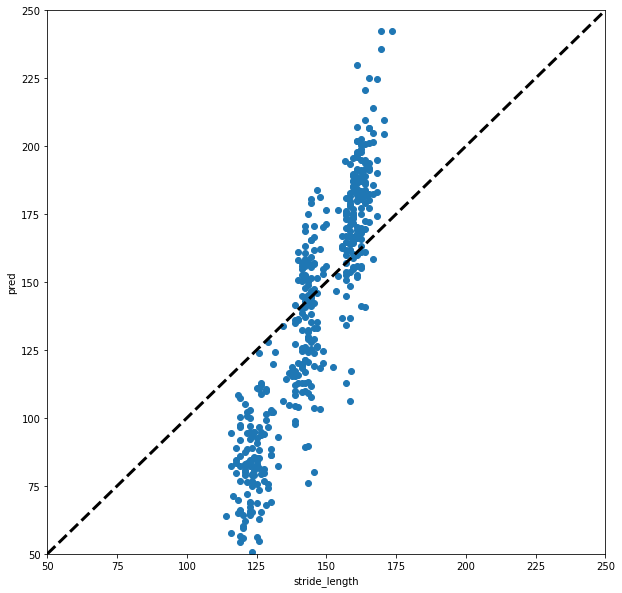

In [146]:
pred = model(inputs_x, inputs_y, inputs_z).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, np.round(pred, 4))
plt.xlim([50, 250])
plt.xlabel('stride_length')
plt.ylim([50, 250])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import os 
import glob
import cv2
import itertools



class Gait_Dataset_Salted(Dataset):
    def __init__(self, file_path, bias=False):
        self.bias = bias
        self.file_path = file_path
        self.inputs_acc, self.inputs_gyr, self.stride_length = get_sensor_salted(file_path, bias=bias)
#         self.inputs_spd = get_speed_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True, bias=bias)
        
    def __len__(self) :
        return len(self.inputs_acc)
    
    def __getitem__(self, idx):
        return self.inputs_acc[idx], self.inputs_gyr[idx], self.stride_length[idx], self.inputs_pst[idx]
    
    
class Gait_Dataset_Axis_Salted(Dataset):
    def __init__(self, file_path, axis=None):
        self.file_path = file_path
        self.inputs_x, self.inputs_y, self.inputs_z, self.stride_length = get_axis_sensor_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True)
        
    def __len__(self) :
        return len(self.stride_length)
    
    def __getitem__(self, idx):
        return self.inputs_x[idx], self.inputs_y[idx], self.inputs_z[idx], self.stride_length[idx], self.inputs_pst[idx]



def get_event_salted(file_path):
    
    df = pd.read_csv(file_path, skiprows=2)
    
    # 압력값 불러오기
    prs = df.filter(regex="R_value")
    prs_mean = np.mean(prs.iloc[:, 0:4], axis=1) 
    
    # Gaussian Filter : Smoothing pressure data
    prs_mean_gf = pd.Series(scipy.ndimage.gaussian_filter1d(prs_mean, 2))
    
    # Level Shift 
    lev_idx = prs_mean_gf > 5 # 가우시안 필터로 인해 0이 아닌 값으로 threshold 설정
    prs_lev = lev_idx.map(lambda x : 1 if x else 0)
    
    # HS, TO Index 추출
    event_idx = []
    for i in range(len(prs_lev)-1):
        if (prs_lev[i] - prs_lev[i+1]) != 0:
            event_idx.append(i)
            
    # HS 이벤트가 먼저 시작하도록 : 나중에 lev shift를 통해 구하는 방법으로 변경하는 것도 괜찮을 듯
    if np.diff(event_idx)[0] < np.diff(event_idx)[1]: # Swing Phase가 Stand Phase보다 길다는 것을 가정 : 장애 데이터에서도 확인 필요
        del event_idx[0]
    
    
    return event_idx

def get_sensor_salted(file_path, normalization=True, bias=False):
    inputs_acc = []
    inputs_gyr = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = acc / 1000 * 9.8066
        
        # x축과 z축에 적용되는 bias 제거(z축의 경우 중력가속도)
        if bias == False:
            acc['R_ACC_X']= acc['R_ACC_X'] - np.mean(acc['R_ACC_X'])
            acc['R_ACC_Z']= acc['R_ACC_Z'] - np.mean(acc['R_ACC_Z']) 
        
        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_acc.append(np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
                inputs_gyr.append(np.transpose(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

            #             inputs_gyr.append(acc_norm[event_hs[i-1]:event_hs[i]])
    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_acc, inputs_gyr, stride_length

def get_axis_sensor_salted(file_path, normalization=True, bias=False):
    inputs_x = []
    inputs_y = []
    inputs_z = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = acc / 1000 * 9.8066
        
        # x축과 z축에 적용되는 bias 제거(z축의 경우 중력가속도)
        if bias == False:
            acc['R_ACC_X']= acc['R_ACC_X'] - np.mean(acc['R_ACC_X'])
            acc['R_ACC_Z']= acc['R_ACC_Z'] - np.mean(acc['R_ACC_Z']) 

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

            
        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_x.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_y.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_z.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_x, inputs_y, inputs_z, stride_length



def get_speed_salted(file_path, bias=False):
    bias = bias
    inputs_acc, _, _ = get_sensor_salted(file_path, normalization=False, bias=bias)
    inputs_spd = []
    for i in range(len(inputs_acc)):
        spd = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_acc[i], dx=(1/100)))
        inputs_spd.append(spd) #m/s
    return inputs_spd

def get_position_salted(file_path, distance=False, bias=False):
    bias = bias
    inputs_spd = get_speed_salted(file_path, bias = bias)
    inputs_pst = []
    for i in range(len(inputs_spd)):
        pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_spd[i], dx=(1/100)))
        if distance==True:
            pst = np.array(np.sum(pst, axis=1))
        inputs_pst.append(pst)
    
    scaler = MinMaxScaler()
    inputs_pst = scaler.fit_transform(inputs_pst)

        
    return inputs_pst


In [6]:
file_path = "D:\gait_dataset/salted/train/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path, normalization=False)
inputs_pst = get_position_salted(file_path, distance=True)
inputs_spd = get_speed_salted(file_path)

In [7]:
inputs_acc[0]

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
R_ACC_X,0.062411,-0.967282,0.317382,2.386575,1.700113,0.533128,0.395835,-0.163141,-0.771150,-0.996702,...,-1.398773,-0.908443,-0.908443,-0.418113,0.003571,0.189897,0.023184,-0.604438,-0.310240,0.582161
R_ACC_Y,-0.382457,-2.245711,-3.608829,-1.510216,-0.804141,-0.460910,-0.107873,-0.117679,0.362844,1.372924,...,14.396089,16.327989,16.327989,18.357955,20.132950,21.398001,21.956977,22.221756,22.555180,22.829765
R_ACC_Z,9.052672,1.609462,-0.646056,1.050486,-0.018433,-1.263872,-0.577410,-0.989287,-2.401437,-2.313178,...,-6.039686,-3.980300,-3.980300,-2.018980,-0.243985,1.217198,2.188052,1.070099,1.246618,0.618996


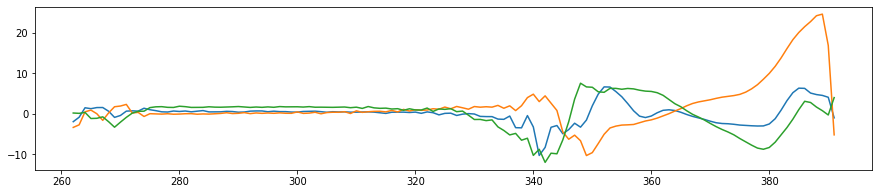

In [15]:
plt.figure(figsize=(15, 3))
plt.plot(inputs_acc[2].transpose())

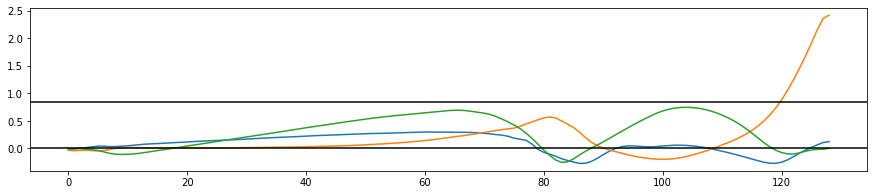

In [16]:
spd = scipy.integrate.cumulative_trapezoid(inputs_acc[2], dx=1/100)
plt.figure(figsize=(15, 3))
plt.plot(pd.DataFrame(spd.transpose()))
plt.axhline(y=0, color='k')
plt.axhline(y=0.833, color='k')

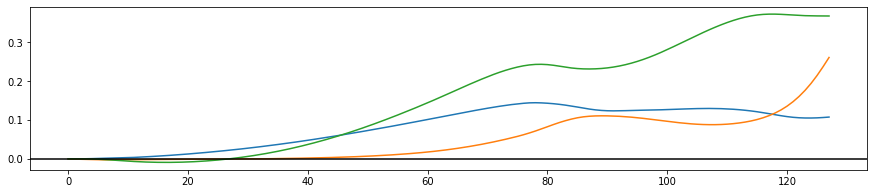

In [17]:
pst = scipy.integrate.cumulative_trapezoid(spd, dx=(1/100))
plt.figure(figsize=(15, 3))
plt.plot(pd.DataFrame(pst.transpose()))
plt.axhline(y=0, color='k')


In [38]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


Virtual devices cannot be modified after being initialized


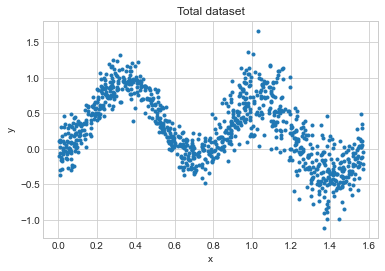

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               200       
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


InternalError: Graph execution error:

Detected at node 'sequential_1/dense_2/MatMul' defined at (most recent call last):
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\taeoo\AppData\Local\Temp\ipykernel_6768\738968537.py", line 69, in <module>
      history = model_lin_reg_tfp.fit(x_train, y_train, epochs=6000, verbose=0)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\functional.py", line 459, in call
      inputs, training=training, mask=mask)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\taeoo\anaconda3\envs\gait\lib\site-packages\keras\layers\core\dense.py", line 221, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_1/dense_2/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential_1/dense_2/MatMul}}]] [Op:__inference_train_function_909]

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

import Data_generator as gen

plt.style.use("seaborn-whitegrid")

X, sigma_square, epsilon, y = gen.DataGenerator(num_of_data=1000).get()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

plt.plot(X, y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Total dataset")
plt.show()


def plot_results(x, y, y_est_mu, title, y_est_std=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, ".", label="y")
    plt.plot(x, y_est_mu, "-y", label="y_estimate_mu")
    plt.plot(x, np.sin(4 * x) * np.sin(5 * x), "-g", label="true_mu")
    if y_est_std is not None:
        plt.plot(x, y_est_mu + 2 * y_est_std, "-r", label="estimate_mu+2std")
        plt.plot(x, y_est_mu - 2 * y_est_std, "-r", label="estimate_mu-2std")

    plt.legend()
    plt.title(title)
    plt.show()


def plot_model_results(model, x, y, title, tfp_model: bool = True):
    si = np.argsort(x)
    x = x[si]
    y = y[si]
    yhat = model(x)
    if tfp_model:
        y_est_mu = yhat.mean()
        y_est_std = yhat.stddev()
    else:
        y_est_mu = yhat
        y_est_std = None
    plot_results(x, y, y_est_mu, title, y_est_std)


def negloglik(y, distr):
    return -distr.log_prob(y)


model_lin_reg_tfp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(100, activation="sigmoid"),
        tf.keras.layers.Dense(1),
    ]
)

model_lin_reg_tfp.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.05), loss=tf.keras.losses.mse
)
model_lin_reg_tfp.summary()
history = model_lin_reg_tfp.fit(x_train, y_train, epochs=6000, verbose=0)

plot_model_results(model_lin_reg_tfp, x_train, y_train, 'Standard NN model train result', tfp_model=False)
plot_model_results(model_lin_reg_tfp, x_test, y_test, 'Standard NN model test result', tfp_model=False)

model_lin_reg_std_nn_tfp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(100, activation="sigmoid"),
        tf.keras.layers.Dense(2),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[:, 0:1], scale=tf.math.softplus(t[:, 1:2])
            )
        ),
    ]
)

model_lin_reg_std_nn_tfp.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.05), loss=negloglik
)
model_lin_reg_std_nn_tfp.summary()
history = model_lin_reg_std_nn_tfp.fit(x_train, y_train, epochs=6000, verbose=0)

plot_model_results(model_lin_reg_std_nn_tfp, x_train, y_train, 'Heteroscedastic NN model train result', tfp_model=True)
plot_model_results(model_lin_reg_std_nn_tfp, x_test, y_test, 'Heteroscedastic NN model test result', tfp_model=True)
results = pd.DataFrame(index=["Train", "Test"])

models = {
    "Linear regression": model_lin_reg_tfp,
    "Neural network + std": model_lin_reg_std_nn_tfp,
}
rmse = tf.keras.metrics.RootMeanSquaredError()
for model in models:
    results[model] = [
        rmse(y_train[:, tf.newaxis], models[model](x_train)
             ).numpy(),
        rmse(y_test[:, tf.newaxis], models[model](x_test)
             ).numpy(),
    ]
results.transpose()
print(results)

results_2 = pd.DataFrame(index=["Train", "Test"])

models = {
    "Linear regression": model_lin_reg_tfp,
    "Neural network + std": model_lin_reg_std_nn_tfp,
}
mae = tf.keras.metrics.MeanAbsoluteError()
for model in models:
    results_2[model] = [
        mae(y_train[:, tf.newaxis], models[model](x_train))
            .numpy(),
        mae(y_test[:, tf.newaxis], models[model](x_test))
            .numpy(),
    ]
results_2.transpose()
print(results_2)